<a href="https://colab.research.google.com/github/fberetta8/ml_finance/blob/main/deep_hedging_bs_conditionalrewards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Hedging

Deep Hedging goes back to the following [paper](https://arxiv.org/abs/1802.03042)  by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood. 

The main idea is to parametrize the hedging strategies (at each time) via neural networks which can depend on input variables chosen by the user, for instance the current price, the past strategy, etc.
This then allows to solve a potentially high dimensional hedging problem for many assets whose dynamics are described by an arbitrary given arbitrage free model even in the presence of transaction costs.

Let us exemplify first the idea by the Black Scholes model in one dimension.

# Deep Hedging exemplified by means of the Black Scholes model

Let $T$ be a finite time horizon and consider on a filtered probability space $(\Omega, {(\mathcal{F}_t)}_{0\leq t\leq T}), \mathcal{F}_T, P)$ a standard Black Scholes model with interest rate $r=0$ and the price of the risky asset $S$ being described by

$$
dS_t=S_t\mu dt + S_t\sigma dW^{\mathbb{P}}_t, \quad S_0=S_0
$$

under the physical measure $\mathbb{P}$. Here $\mu \geq 0$, $\sigma \neq 0$, $S_0 >0$ and $W^{\mathbb{P}}$ is a Brownian motion (under $\mathbb{P}$).

Under the unique risk neutral probability measure, denoted by $\mathbb{Q}$, the dynamics are then given by

$$
dS_t= S_t\sigma dW_t, \quad S_0=S_0
$$

where $W$ is a $\mathbb{Q}$ Brownian motion 

We consider here the problem of hedging a $\mathcal{F}_T$-measurable claim $f(S_T)$. In the case of the Black Scholes model the hedging strategy can be found by the Delta hedge, i.e. 

$$
\Delta(t,s)=\partial_s \mathbb{E}_{Q}[f(S_T)| S_t=s].
$$

In more involved models this is no longer possible. In particular in incomplete models not every claim can be hedged and we thus need to optimize a hedging criterion. We here consider a __quadratic hedging criterion__ but other risk measures are of course also possible.

Let $\pi$ denote the price of the option, i.e. $\mathbb{E}_Q[f(S_T)]$. Then the goal is solve the following optimization problem 

$$
\inf_{\pi \text{ premium}, \, H \text{ predictable }}\mathbb{E}[( f(S_T)- \pi- (H\bullet S)_T)^2],
$$

where $(H_t)$ ranges over all predictable process and $(H \bullet S)_T= \int_0^T H_t dS_t$ denotes the stochastic Ito integral. Optimizing over all predictable processes is infeasable. 

Therefore we choose to specify $H_t$ in a smaller set: for each $t$ as a neural network whose input can be specified.  In complete Markovian models, as it is the case of the Black Scholes model, we know from the delta hedging strategy that it makes sense to parameterize $H_t$ as a function of the current price $S_t$.  In the current setting we therefore choose that the input of each neural network in the implementation below depends only on the current price, i.e. 

$$
H_t=g_t(S_t)
$$

and $g_t$ denotes a neural network.

We can view the above as supervised learning problem: the input data $x_i$ correspond to trajectories of $(S_t(\omega_i))_{0 \leq t \leq T}$, the output $y_i$ should be $0$ and the
the loss function is given by 

$$
\mathcal{L}=  \frac{1}{K}\sum_i \left(f(S_T(\omega_i))- \pi- \int_0^T g_t(S_t (\omega_i)) dS_t(\omega_i)\right)^2.
$$

To implement this we need to generate input data which will be our training data set. Consider the log price of $S_t$ under $\mathbb{Q}$, i.e.

$$
d\log(S_t)= -\frac{\sigma^2}{2} dt + \sigma dW_t.
$$

The practical implementation requires a time discretization.
If we discretize our time interval $[0,T]$ in $N$ time steps of length $T/N$ we can write 

$$
\log(S_i)= \log(S_{i-1}) -\frac{\sigma^2}{2} \frac{T}{N} + \sigma \sqrt{\frac{T}{N}} Z_i, i=1, \ldots, N
$$

where $Z_i$ are independent $N(0,1)$ distributed random variables. The discretized price $(S_0, S_1, \ldots S_N)$ is obtained by exponentiation.

In this disretized form the whole trajetory of the price $(S_0, S_1, \ldots S_N)$ is therefore determined by $(S_0, Z_1, \ldots, Z_N)$ or in other words $(S_0, X_1, \ldots, X_N)$  where $X_i$ are independent  $N(-\frac{\sigma^2}{2} \frac{T}{N} ,\sigma^2 \frac{T}{N})$ distributed random variables. Considering $K$ many samples thereof constitutes the input training data set. The outputs are simply $K$ zeros.

In the above loss function we also need to disretize the 
stochastic integral

$$
\int_0^T g_t(S_t (\omega)) dS_t(\omega).
$$

We do this by choosing $N$ neural networks $g_0, \ldots, g_{N-1}$ and disretizing the integral as follows:

$$
\sum_{i=0}^{N-1} g_i(S_i(\omega)) (S_{i+1}(\omega)-S_i(\omega)) \, .
$$


In contrast to the original deep hedging approach we consider two training data sets here (xtrain and xtrain_red), where the second one is not a random sample Ktrain trajectories, but rather a set of trajectories, where R initial steps coincide for sets of N_red trajectories.

In [ ]:
#%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

import copy

In [ ]:
N=100 # time disrectization
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0 # f(S)=(S-1)_+ European Call Contract
sigma=0.2 # volatility in Black Scholes

In [ ]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price from BS formula

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 1 strike 1.0 maturity 1 and volatility 0.2 is equal to 0.07965567455405798


In [ ]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [ ]:
R=50 # reduction
# architecture is the same for all networks
layers_red = []
for j in range(R):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]
        
for j in range(R,N):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=False,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price_red = Input(shape=(m,))
hedge_red = Input(shape=(m,))
hedgeeval_red = Input(shape=(m,))
premium_red = Input(shape=(m,))

inputs_red = [price_red]+[hedge_red]+[hedgeeval_red]+[premium_red]
outputhelper_red=[]

premium_red = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium_red)

for j in range(N):
    strategy_red = price_red
    strategyeval_red=hedgeeval_red
    for k in range(d):
        strategy_red= layers_red[k+(j)*d](strategy_red) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval_red=layers_red[k+(j)*d](strategyeval_red)
    incr_red = Input(shape=(m,))
    logprice_red= Lambda(lambda x : K.log(x))(price_red)
    logprice_red = Add()([logprice_red, incr_red])
    pricenew_red=Lambda(lambda x : K.exp(x))(logprice_red)# creating the price at time j+1
    priceincr_red=Subtract()([pricenew_red, price_red])
    hedgenew_red = Multiply()([strategy_red, priceincr_red])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge_red = Add()([hedge_red,hedgenew_red]) # building up the discretized stochastic integral
    inputs_red = inputs_red + [incr_red]
    outputhelper_red = outputhelper_red + [strategyeval_red]
    price_red=pricenew_red
payoff_red= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price_red) 
outputs_red = Subtract()([payoff_red,hedge_red]) 
outputs_red = Subtract()([outputs_red,premium_red]) # payoff minus price minus hedge 
outputs_red= [outputs_red] + outputhelper_red +[premium_red]
outputs_red = Concatenate()(outputs_red)

model_hedge_strat_red = Model(inputs=inputs_red, outputs=outputs_red)

In [ ]:
gamma = 1.0
grid = [(i/N)**gamma*T for i in range(N+1)]

Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.ones((Ktrain,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [ ]:
N_red=1000
xtrain_red=copy.deepcopy(xtrain)
for i in range(R):
    a = xtrain_red[4+i]
    for k in range(int(Ktrain/N_red)):
        for l in range(N_red):
            a[k*N_red+l,:]=a[k*N_red,:]
    xtrain_red[4+i]=a

In [ ]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z

In [ ]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)
model_hedge_strat_red.compile(optimizer='adam',loss=custom_loss)

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True,batch_size=1000)
weights = model_hedge_strat.get_weights()
model_hedge_strat_red.set_weights(weights)
#for i in range(5):
#    model_hedge_strat_red.fit(x=xtrain_red,y=ytrain, epochs=1,verbose=True,batch_size=10000)
#weights = model_hedge_strat_red.get_weights()
#model_hedge_strat.set_weights(weights)

100/100 [==============================] - 9s 85ms/step - loss: 9.6173e-05


3125/3125 [==============================] - 38s 11ms/step


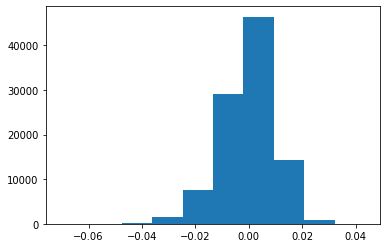

0.00979633
0.07968736


In [ ]:
a = model_hedge_strat.predict(xtrain)
plt.hist(a[:,0])
plt.show()
print(np.std(a[:,0]))
print(np.mean(a[:,N+1]))

In [ ]:
model_hedge_strat.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 add (Add)                      (None, 1)            0           ['lambda[0][0]',                 
                                                                  'input_5[0][0]']            

In [ ]:
Ktest=50
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [0.5*np.ones((Ktest,m))+np.cumsum(np.ones((Ktest,m))*(1.5-0.5)/Ktest,axis=0)] +#change this if you go to higher dimensions
          [priceBS*np.ones((Ktest,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktest,m)) for i in range(N)])

y=model_hedge_strat.predict(xtest)[:,10]
print(y)

2/2 [==============================] - 0s 19ms/step
[-3.39018643e-01 -3.16566795e-01 -2.92371839e-01 -2.66422510e-01
 -2.38724813e-01 -2.09301904e-01 -1.78193256e-01 -1.45453677e-01
 -1.11152351e-01 -7.53725618e-02 -3.82102877e-02  2.25214288e-04
  3.98148447e-02  8.04268569e-02  1.21918336e-01  1.64136395e-01
  2.06918046e-01  2.50090539e-01  2.93475062e-01  3.36885184e-01
  3.80132347e-01  4.23028082e-01  4.65387166e-01  5.07032514e-01
  5.47796845e-01  5.87529540e-01  6.26096487e-01  6.63384557e-01
  6.99301898e-01  7.33777523e-01  7.66763985e-01  7.98232794e-01
  8.28175426e-01  8.56598914e-01  8.83526206e-01  9.08990562e-01
  9.33036089e-01  9.55713034e-01  9.77078438e-01  9.97192025e-01
  1.01611555e+00  1.03391063e+00  1.05063999e+00  1.06636488e+00
  1.08114398e+00  1.09503520e+00  1.10809195e+00  1.12036717e+00
  1.13190949e+00  1.14276493e+00]


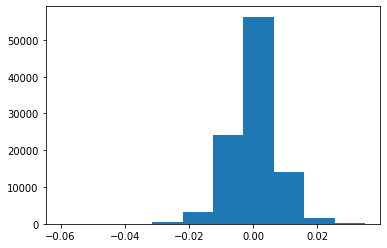

0.006939427165164688
0.0003789796828809427


In [ ]:
logincrements = xtrain[4:4+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain,N))
for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:,k+1] = price[:,k]*np.exp(helper[:])
    hedge[:] = hedge[:] + scipy.norm.cdf((np.log(price[:,k]/strike)+0.5*(T-grid[k+1])*sigma**2)/(np.sqrt(T-grid[k+1])*sigma))*(price[:,k+1]-price[:,k])
hedge[:]= hedge[:]-0.5*(np.abs(price[:,N-1]-strike)+(price[:,N-1]-strike))+priceBS
plt.hist(hedge)
plt.show()
print(np.std(hedge))
print(np.mean(hedge))

2/2 [==============================] - 0s 19ms/step


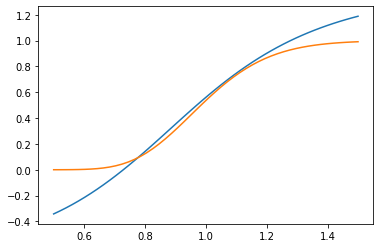

In [ ]:
l =20
s=np.linspace(0.5,1.5,Ktest)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-grid[l])*sigma**2)/(np.sqrt(T-grid[l])*sigma))
#plt.plot(s,z)
#plt.plot(s,y)
y=model_hedge_strat.predict(xtest)[:,l]
plt.plot(s,y,s,z)
plt.show()

If we want to calculate indifference prices, we can use the second code (showing us also very explicitly the hedging strategies), but for an untrainable premium network: we shall just fix the premium network to be the identity and map different values (around reasonable prices) to the hedging portfolio. We also take as an input of the hedging strategy the initial capital, in order to parametrize the dependence on the initial capital.

Additionally we have to change the loss function from mean square to an everywhere defined utility function $ u $, i.e. a concave, increasing function with argument space the whole real line. Think for instance of $ x \mapsto 1 - \exp(-x) $.

Let $p_s$ denote the indifference price (of the seller) of the option (given no additional investment into a portfolio). Then the goal is solve the following optimization problem 
$$
u(0) = \sup_{H \text{ predictable }}\mathbb{E}\big[ u(- f(S_T) + p_s + (H\bullet S)_T) \big],
$$
where $(H_t)$ ranges over all predictable process and $(H \bullet S)_T= \int_0^T H_t dS_t$ denotes the stochastic Ito integral, i.e.~the seller wants to receive a premimum $p_s$ for having the liability in its books and hedging it by self-financing portfolio (given by $H$). The indifference price $p_b$ of the buyer satisfies in contrast
$$
u(0) = \sup_{H \text{ predictable }}\mathbb{E}\big[ u(f(S_T) - p_b - (H\bullet S)_T) \big],
$$
where the buyer is willing to pay $p_b$ to obtain the asset $f(S_T)$ instead of mimicking it by a portfolio on her own. The price of the seller will be higher than previously calculated price with the $L^2$ criterion, whereas the price of the buyer will be smaller.

In [ ]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=False,
                kernel_initializer=initializers.RandomNormal(1.0,0.0),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0.0,0.0))(premium)

for j in range(N):
    strategy = Concatenate()([price,premium])
    strategyeval=Concatenate()([hedgeeval,premium])
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [ ]:
Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.linspace(0.5,1.5,Ktrain)]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [ ]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.exp(-z))
    return z

In [ ]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

Epoch 1/1
100000/100000 [==============================] - 296s 3ms/step - loss: 1.0041
Epoch 1/1
100000/100000 [==============================] - 246s 2ms/step - loss: 1.0024
Epoch 1/1
100000/100000 [==============================] - 245s 2ms/step - loss: 1.0023
Epoch 1/1
100000/100000 [==============================] - 246s 2ms/step - loss: 1.0021
Epoch 1/1
100000/100000 [==============================] - 246s 2ms/step - loss: 1.0020


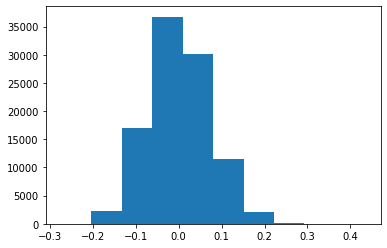

0.07148296
0.07965567


In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
plt.hist(model_hedge_strat.predict(xtrain)[:,0])
plt.show()
print(np.std(model_hedge_strat.predict(xtrain)[:,0]))
print(np.mean(model_hedge_strat.predict(xtrain)[:,N+1]))

In [ ]:
Ktest = 10**5
for x in np.linspace(0.96,1.0,10):
    xtest = ([initialprice*np.ones((Ktest,m))] +
              [np.zeros((Ktest,m))]+
              [np.linspace(0.5,1.5,Ktest)] +#change this if you go to higher dimensions
              [priceBS*x*np.ones((Ktest,m))]+
              [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])
    y=np.mean(np.exp(-model_hedge_strat.predict(xtest)[:,0]))
    print(y)

0.9995627
0.9993324
0.99969375
0.99989593
1.0009139
1.0008274
1.0014551
1.0020412
1.0022228
1.0022191
